## Brazilian E-Commerce Public Dataset by Olist

This Jupyter Notebook is related to the Brazilian E-Commerce Public Dataset by Olist.

- Dataset: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

#### About the dataset

Brazilian E-Commerce Public Dataset by Olist

Welcome! This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.
<br><br>

This project serves as a portfolio piece by walking through end-to-end data processing, insightful EDA, and actionable analytics. Using the Olist Brazilian E-Commerce dataset’s rich, multi-dimensional structure allowed the exploration of various aspects of customer behavior and consumer analytics.

## Importing the libraries and loading the data

In [51]:
# Brazilian E-Commerce by Olist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

pd.set_option('display.max_columns', 600)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Loading the data into individual dataframes
customers = pd.read_csv('data/olist_customers_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
order_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
prod_cat = pd.read_csv('data/product_category_name_translation.csv')
geolocation = pd.read_csv('data/olist_geolocation_dataset.csv')
order_payments = pd.read_csv('data/olist_order_payments_dataset.csv')
orders = pd.read_csv('data/olist_orders_dataset.csv')
sellers = pd.read_csv('data/olist_sellers_dataset.csv')


In [54]:
print(f"Number of unique customer in customers df: {len(customers['customer_id'])}.")
print(f"Number of unique customer in orders df: {len(orders['customer_id'])}.")
print(f"Number of unique customer in orders df: {len(orders['order_id'])}.")

Number of unique customer in customers df: 99441.
Number of unique customer in orders df: 99441.
Number of unique customer in orders df: 99441.


## Initial exploration and data cleaning
First of all, I briefly reviewed each dataset's structure to identify missing or inconsistent values or data types.<br><br>
As expected, there are several review sections missing from the Order Reviews dataset.
Some information about product attributes and dimensions is missing from the Products dataset.<br><br>
Also, there is considerable information regarding carrier, customer and delivery dates missing from the Orders dataset.


In [73]:
print("Customers:",customers.info(), "\n")
print("Order Items:", order_items.info(), "\n")
print("Order Reviews:", order_reviews.info(), "\n")
print("Products:", products.info(), "\n")
print("Product Category Translation:", prod_cat.info(), "\n")
print("Geolocation:", geolocation.info(), "\n")
print("Order Payments:", order_payments.info(), "\n")
print("Orders:", orders.info(), "\n")
print("Sellers:", sellers.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
Customers: None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  1126

### Converting date columns
There are several date columns. I converted the order timestamp columns to proper datetime formats<br><br>
This is crucial for time series analysis.

In [4]:
# Columns with time stamps and conversion to datetime type
date_cols = ['order_purchase_timestamp', 'order_approved_at', 
             'order_delivered_carrier_date', 'order_delivered_customer_date', 
             'order_estimated_delivery_date']

for col in date_cols:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')

### Checking missing values

In [75]:
#Cheking missing values
dataset_dict = {
    'customers':customers, 'order_items':order_items, 'orderreviews':order_reviews,
    'products':products,'prod_cat':prod_cat, 'geolocation':geolocation,
    'order_payments':order_payments, 'order_sellers':orders, 'sellers':sellers
    }

for name, df in dataset_dict.items():
    print(f"{name}")
    print(i.isna().sum())
    print()

customers
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

order_items
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

orderreviews
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

products
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

prod_cat
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

geolocation
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city            

### Looking for duplicated data
Interestingly, the is a lot of duplicated data regarding geolocation. This is expected given the location of frequent customers.

In [76]:
for name, df in dataset_dict.items():
    print(f"{name}")
    print(df.duplicated().sum())
    print()

customers
0

order_items
0

orderreviews
0

products
0

prod_cat
0

geolocation
261831

order_payments
0

order_sellers
0

sellers
0



## Feature Engineering and Data Integration
### Order Value Metrics
Calculating the total value per order is crucial for revenue analysis and customer segmentation. Grouping orders is essential to aggregate multi-item orders.<br><br>
In the oder items dataset, it was necessary to compute the total order value (product price + freight). Since an order may contain multiple items, group by order_id.<br><br>
Later, the total value of each specific order was added to the "orders" dataset.

In [5]:
# Fisrt, create a new column for total value per order item
order_items['order_item_value'] = order_items['price'] + order_items['freight_value']

# Then, aggregate values per order_id
order_value = order_items.groupby('order_id').agg(
    total_order_value=('order_item_value', 'sum'),
    total_price=('price', 'sum'),
    total_freight=('freight_value', 'sum')
).reset_index()

print(order_value.head())


                           order_id  total_order_value  total_price  \
0  00010242fe8c5a6d1ba2dd792cb16214              72.19        58.90   
1  00018f77f2f0320c557190d7a144bdd3             259.83       239.90   
2  000229ec398224ef6ca0657da4fc703e             216.87       199.00   
3  00024acbcdf0a6daa1e931b038114c75              25.78        12.99   
4  00042b26cf59d7ce69dfabb4e55b4fd9             218.04       199.90   

   total_freight  
0          13.29  
1          19.93  
2          17.87  
3          12.79  
4          18.14  


### Merging "order_items" and "orders"

In [6]:
# Merge total order value into orders dataset based on order_id
orders = orders.merge(order_value, on='order_id', how='left')

orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'total_order_value', 'total_price', 'total_freight'],
      dtype='object')

## Explorator Data Analysis (EDA)
### Revenue Over Time
The initial exploration was done to gather information regarding the monthly revenue from the "orders" data.
Despite the steady growth from december-2016 to march-2018, and a plateau in 2018, there was a **drastic** fall in revenue in september and october of 2018.

In [ ]:
orders['order_month'] = orders['order_purchase_timestamp'].dt.to_period('M').astype(str)

monthly_revenue = orders.groupby('order_month')['total_order_value'].sum().reset_index()

fig = go.Figure(data=go.Scatter(x=monthly_revenue['order_month'], 
                                 y=monthly_revenue['total_order_value'], 
                                 mode='lines+markers', 
                                 marker=dict(color='royalblue')))
fig.update_layout(
    plot_bgcolor='white',
    title=dict(
        text='Monthly Revenue Trend',
        y=0.95,
        x=0.5,
        xanchor='center',
        yanchor='top',
        font=dict(size=24)
    ),
    xaxis_title='Month',
    yaxis_title='Revenue (Total Order Value)',
    yaxis=dict(gridcolor='lightgray'),
    width=800,
    height=600,
)

fig.show()

### Customer Segmentation Using RFM Analysis
Later, I segmented customers based on Recency (R), Frequency (F), and Monetary (M) values.<br><br>
I began constructing a RFM table merging the "orders" and "customer" dataframes, then computing the RFM metrics.<br><br>
Then, a normalized dataframe was created in order to display RFM scores on a scale from 1 to 5 (hight-value customer).<br><br>
Each customer was scored on these three dimensions and the combined scores identify high-value customers (score = 555) and low-value customers (score = 111).<br><br>
In order to ensure a balanced distribution, pd.qcut() was used to create quantile-based scoring (5 bins). While the highest scoring customers should be retained, the lowest and intermediate niche groups should be selected for targeted marketing.


In [11]:
orders_customers = orders.merge(customers, on='customer_id', how='left')

# analysis reference date was defined as one day after the latest order
analysis_date = orders_customers['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# Grouping by customer to compute RFM metrics:
rfm = orders_customers.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (analysis_date - x.max()).days,
    'order_id': 'nunique',
    'total_order_value': 'sum'
}).reset_index()

rfm.columns = ['customer_unique_id', 'recency', 'frequency', 'monetary']

rfm.describe()


recency     frequency      monetary
count  96096.000000  96096.000000  96096.000000
mean     288.735691      1.034809    164.872141
std      153.414676      0.214384    227.938658
min        1.000000      1.000000      0.000000
25%      164.000000      1.000000     62.390000
50%      269.000000      1.000000    107.270000
75%      398.000000      1.000000    182.237500
max      773.000000     17.000000  13664.080000

In [12]:
# The labels for recency are inverted since a lower recency is better for business
rfm['R_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
# Frequency and monetary: higher is better
rfm['F_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['monetary'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)

rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

top_rfm_scores = rfm['RFM_score'].value_counts().nlargest(10)

fig = go.Figure(data=[
    go.Bar(
        x=top_rfm_scores.index,
        y=top_rfm_scores.values,
        text=top_rfm_scores.values,
        textposition='auto',
        marker=dict(color='teal')
    )
])

fig.update_layout(
    title=dict(
        text='Top 10 RFM Scores Distribution',
        y=0.95,
        x=0.5,
        xanchor='center',
        yanchor='top',
        font=dict(size=24)
    ),
    title_x=0.5,
    xaxis_title='RFM Score',
    yaxis_title='Number of Customers',
    width=1200,
    height=600,
    plot_bgcolor='white',
    yaxis=dict(gridcolor='lightgray'),
)



fig.show()

### Customer Segmentation Analysis with Kmeans clustering
Next, I used the Kmeans algorithm to further the customer segmentation analysis using MinMaxScaler to normalize the RFM values (0 to 1).<br><br>
Clustering with Kmeans offers a scalable and easy to understand data-driven segmentation approach.<br><br>

In [13]:
rfm_data = rfm[['recency', 'frequency', 'monetary']].copy()

scaler = MinMaxScaler()
rfm_normalized = scaler.fit_transform(rfm_data)
rfm_normalized_df = pd.DataFrame(rfm_normalized, columns=['recency', 'frequency', 'monetary'])

#### Choosing the number of clusters

The optimal number of clusters was determined using a combination of Elbow and Silhouette analysis.

Usually, there is not a clear elbow inflection in inertia X number of clusters plot. In theses cases, using the Silhouette Score can be a useful alternative.

The following conditions were used to pick the number of clusters using the Silhouette plots, as nicely described by Anmol Tomar in https://builtin.com/data-science/elbow-method:

- For a particular K, all the clusters should have a Silhouette score greater than the average score of the data set represented by the red-dotted line. The x-axis represents the Silhouette score.

- There shouldn’t be wide fluctuations in the size of the clusters. The width of the clusters represents the number of data points.

A k= 4 was chosen.


In [14]:
# Elbow
inertia = []
silhouette = []

K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42,)
    kmeans.fit(rfm_normalized)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(rfm_normalized, kmeans.labels_))

In [15]:
# Elbow scores
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(K), y=inertia, mode='lines+markers', name='Inertia'))
fig.update_layout(
    title=dict(
        text='Elbow Method for Optimal K',
        y=0.95,
        x=0.5,
        xanchor='center',
        yanchor='top',
        font=dict(size=24)
    ),
    xaxis_title='Number of Clusters (k)',
    yaxis_title='Inertia',
    width=800,
    height=600,
    plot_bgcolor='white',
    yaxis=dict(gridcolor='lightgray'),
    title_x=0.5,
)
fig.show()

# silhouette scores
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=list(K), y=silhouette, mode='lines+markers', name='Silhouette Score', line=dict(color='green')))
fig2.update_layout(
    title=dict(
        text='Silhouette Score for Different k',
        y=0.95,
        x=0.5,
        xanchor='center',
        yanchor='top',
        font=dict(size=24)
    ),
    xaxis_title='Number of Clusters (k)',
    yaxis_title='Silhouette Score',
    width=800,
    height=600,
    plot_bgcolor='white',
    yaxis=dict(gridcolor='lightgray'),
    title_x=0.5,
)
fig2.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

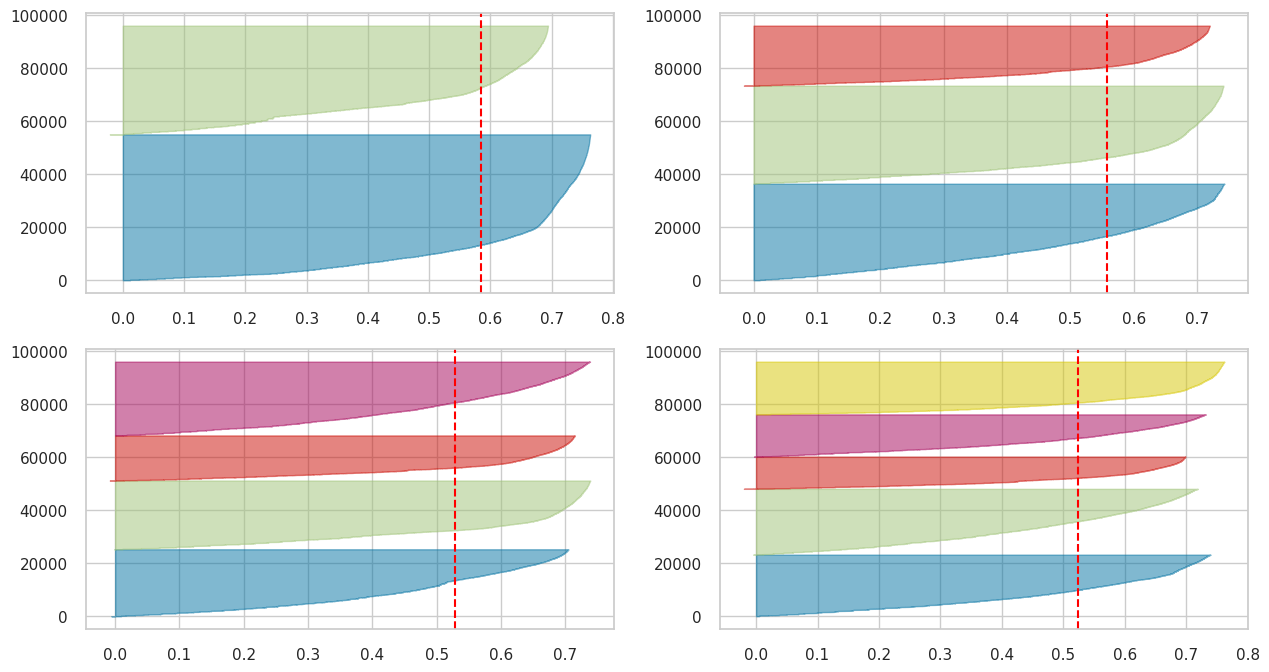

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in K:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''


In [17]:
visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
visualizer.fit(rfm_normalized) 

IndexError: index 2 is out of bounds for axis 0 with size 2

In [23]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
rfm['cluster'] = kmeans.fit_predict(rfm_normalized)

In [24]:
rfm[['recency_norm', 'frequency_norm', 'monetary_norm']] = rfm_normalized_df

fig = px.scatter_3d(
    rfm, x='recency_norm', y='frequency_norm', z='monetary_norm',
    color='cluster',
    # color_continuous_scale='Viridis',
    labels={'recency_norm': 'Recency', 'frequency_norm': 'Frequency', 'monetary_norm': 'Monetary'},
    opacity=0.7
)
fig.update_layout(
    title=dict(
        text='KMeans Clustering of Customers Based on RFM (Normalized)',
        y=0.95,
        x=0.5,
        xanchor='center',
        yanchor='top',
        font=dict(size=24)
    ),
    width=800,
    height=600,
    plot_bgcolor='white',
    yaxis=dict(gridcolor='lightgray'),
    title_x=0.5,
)

fig.show()

In [105]:
rfm_normalized_df

recency  frequency  monetary
0      0.207254        0.0  0.010385
1      0.211140        0.0  0.001990
2      0.757772        0.0  0.006310
3      0.477979        0.0  0.003192
4      0.435233        0.0  0.014409
...         ...        ...       ...
96091  0.641192        0.0  0.151303
96092  0.401554        0.0  0.006190
96093  0.799223        0.0  0.008230
96094  0.217617        0.0  0.009784
96095  0.689119        0.0  0.005237

[96096 rows x 3 columns]

### Grouped RFM Segmentation

For this section, I decided to create a new F+M dimension and normalize it.

I started by computing the combined FM score and then “rescale” it to a 1–5 range.

Later, a assign_rfm_segment() funcion was created to assign a segment for each client.

Below is a custom “region-based” approach using Matplotlib and Seaborn that merges contiguous "cells" belonging to the same segment into a single colored block and aggregates the total count and percentage for that segment. This addresses the key differences from the simple 5×5 heatmap.

This visualization could also be done other tools, like Power Bi.

In [ ]:
sns.set(style='whitegrid')

# Compute F+M and use normalize it to 1–5
rfm['FM_score'] = rfm['F_score'] + rfm['M_score']
min_fm = rfm['FM_score'].min()
max_fm = rfm['FM_score'].max()
rfm['FM_norm'] = ((rfm['FM_score'] - min_fm) / (max_fm - min_fm)) * 4 + 1
rfm['FM_norm'] = rfm['FM_norm'].round().astype(int)

# Here comes the segments based on R and FM
def assign_rfm_segment(row):
    R = row['R_score']
    FM = row['FM_norm']
    if R == 5 and FM == 5:
        return 'Champions'
    elif (R in [4,5]) and FM == 4:
        return 'Loyal Customers'
    elif R == 3 and FM >= 4:
        return 'Potential Loyalists'
    elif R == 5 and FM <= 3:
        return 'New Customers'
    elif R == 4 and FM <= 3:
        return 'Promising'
    elif R == 3 and FM <= 3:
        return 'Need Attention'
    elif R == 2 and FM >= 4:
        return 'About to Sleep'
    elif R == 2 and FM <= 3:
        return 'At Risk'
    elif R == 1 and FM >= 4:
        return "Can't Lose Them"
    elif R == 1 and FM <= 3:
        return 'Hibernating'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(assign_rfm_segment, axis=1)

# Group and aggregate
grouped = rfm.groupby(['R_score', 'FM_norm', 'Segment']).agg(
    count=('customer_unique_id', 'count')
).reset_index()

total_customers = rfm['customer_unique_id'].nunique()
grouped['percentage'] = (grouped['count'] / total_customers * 100).round(1)


In [ ]:
# Summarize per segment across all "cells" in the chart
segment_summary = grouped.groupby('Segment').agg(
    min_R=('R_score', 'min'),
    max_R=('R_score', 'max'),
    min_FM=('FM_norm', 'min'),
    max_FM=('FM_norm', 'max'),
    total_count=('count', 'sum'),
    total_percent=('percentage', 'sum')
).reset_index()

# Define a color for each segment in the chart
color_map = {
    'Champions':        '#66C2A5',
    'Loyal Customers':  '#FC8D62',
    'Potential Loyalists': '#8DA0CB',
    'New Customers':    '#E78AC3',
    'Promising':        '#A6D854',
    'Need Attention':   '#FFD92F',
    'About to Sleep':   '#E5C494',
    'At Risk':          '#F4CAE4',
    "Can't Lose Them":  '#B3DE69',
    'Hibernating':      '#F1E2CC',
    'Others':           '#d3d3d3'
}


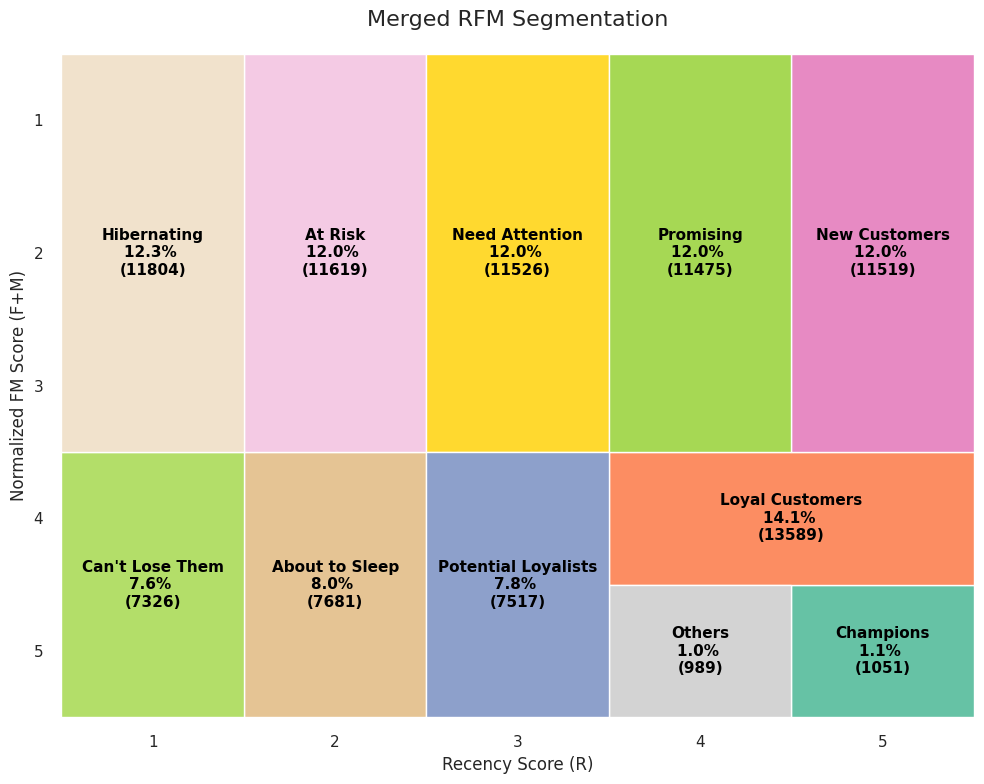

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax.set_xticks([1,2,3,4,5])
ax.set_yticks([1,2,3,4,5])
ax.set_xlim(0.5, 5.5)
ax.set_ylim(0.5, 5.5)
ax.invert_yaxis()
ax.set_xlabel("Recency Score (R)")
ax.set_ylabel("Normalized FM Score (F+M)")

for spine in ax.spines.values():
    spine.set_visible(False)

# Region-base" approach - for each segment, create one bounding rectangle for contiguous "cells"
for _, row in segment_summary.iterrows():
    seg_name = row['Segment']
    c = color_map.get(seg_name, '#ffffff')
    minR, maxR = row['min_R'], row['max_R']
    minFM, maxFM = row['min_FM'], row['max_FM']
    sum_count = row['total_count']
    sum_perc = row['total_percent']
    
    # The bounding box corners in data coordinates
    # left: minR - 0.5
    # right: maxR + 0.5
    # top: minFM - 0.5
    # bottom: maxFM + 0.5
    # Y is inverted, so top < bottom in data coords:
    # I will certainly not remember this in the future
    left = minR - 0.5
    right = maxR + 0.5
    top = minFM - 0.5
    bottom = maxFM + 0.5
    
    rect = plt.Rectangle(
        (left, top),
        (right - left),
        (bottom - top),
        facecolor=c,
        edgecolor='white'
    )
    ax.add_patch(rect)
    
    # Annotation in the middle center
    center_x = (minR + maxR)/2
    center_y = (minFM + maxFM)/2
    seg_text = f"{seg_name}\n{sum_perc:.1f}% \n({int(sum_count)})"
    ax.text(center_x, center_y, seg_text,
            ha='center', va='center',
            fontsize=11, color='black', fontweight='bold')

ax.set_title("Merged RFM Segmentation", fontsize=16, pad=20)
plt.tight_layout()
plt.show()


### Churn Rate Analysis

In the context of the Olist dataset, a churned customer could be defined as one who has made only a single purchase within the dataset's timeframe. Conversely, retained customers are those with multiple purchases.

In [ ]:
# Filter only delivered orders
delivered_orders = orders[orders["order_status"] == "delivered"]

customer_order_counts = delivered_orders.groupby("customer_id")["order_id"].nunique()

# Total number of unique customers
total_customers = customer_order_counts.shape[0]

# Customers with only one delivered order (potentially churned)
churned_customers = customer_order_counts[customer_order_counts == 1].shape[0]

churn_rate = (churned_customers / total_customers) * 100
print(f"Churn rate: {churn_rate}%.")

Churn rate: 100.0%.


That was strangely high. So, I took a look at the number of unique customers on the dataset and found the culprit.
Maybe, the anonymization process selected was not appropriate. In that case, further analysis could be compromised.

In [49]:
print(orders['customer_id'].info())
print()
print(f"Number of unique custumer_id entries: {len(orders['customer_id'].unique())}.")

<class 'pandas.core.series.Series'>
RangeIndex: 99441 entries, 0 to 99440
Series name: customer_id
Non-Null Count  Dtype 
--------------  ----- 
99441 non-null  object
dtypes: object(1)
memory usage: 777.0+ KB
None

Number of unique custumer_id entries: 99441.
